## Locking module - Vessels passing a lock
In this notebook, we set up a basic simulation where two vessels move over a 1D netork path. We add a lock on the graph and see how the vessels pass the lock. 

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [17]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
import shapely.geometry
from shapely.geometry import Point, LineString
from shapely.geometry.base import BaseGeometry
import pyproj
from geopy.distance import geodesic

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim
from opentnsim import core as core_module
from opentnsim import energy as energy_module
from opentnsim import graph as graph_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import lock as lock_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots

In [18]:
# create a basic plotting method (plotly based, with labels properly positioned)
def plot_graph(FG):
    
    def compute_distance(WGS84, origin: shapely.Geometry, destination: shapely.Geometry):
        """Determine the distance based on great circle path from origin to destination."""
        orig = shapely.geometry.shape(origin)
        dest = shapely.geometry.shape(destination)
        _, _, distance = WGS84.inv(orig.x, orig.y, dest.x, dest.y)
    
        return distance
        
    # Extract node positions
    pos = {node: (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y) for node in FG.nodes}
    
    # Create Plotly figure
    fig = make_subplots(rows=1, cols=1)
    
    # Add edges to the figure
    for edge in FG.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        fig.add_trace(go.Scatter(x=[x0, x1], y=[y0, y1], mode='lines', line=dict(width=4, color='blue')))
    
    
    # Add nodes to the figure
    for node in FG.nodes():
        x, y = pos[node]
        fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers+text', text=['<b> {} </b>'.format(node)], textposition='middle center',
                                 marker=dict(size=20, color='red')))
    
    # Add labels to the figure
    for index, edge in enumerate(FG.edges):
        # Add label '100 km' over the trace with the same y position as the node labels
        mid_x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
        
        # Use the same y position as the nodes
        mid_y =  pos[edge[0]][1]  

        # Calculate distance
        distance = compute_distance(pyproj.Geod(ellps="WGS84"), FG.nodes[edge[0]]['geometry'], FG.nodes[edge[1]]['geometry'])
        
        # add edge length
        fig.add_trace(go.Scatter(x=[mid_x], y=[mid_y], mode='text', text=['<b>{:.1f} km</b><br>'.format(distance/1000)], 
                                 textposition='top center'))
        # add edge depth
        fig.add_trace(go.Scatter(x=[mid_x], y=[mid_y], mode='text', text=['<br><b> {} </b>'.format(FG.edges[edge]['Info']['GeneralDepth'])],
                                 textposition='bottom center'))
    
    # Update layout
    fig.update_layout(
        {
            'plot_bgcolor':  'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        },
        margin={"t": 0, "b": 0, "l": 0, "r": 0},
        height=80,
        showlegend=False)
    
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)

    return fig

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _ConsumesEnergy_ - enables calculation of resistance, required power and emissions

In [19]:
#We create a type element that schematisizes a vessel
def create_vessel_locking(env, name, origin, destination, arrival_time, vessel_type, L, B, T, v):

    Vessel = type('Vessel', (lock_module.HasLockComplex,
                             vessel_module.IsVessel,
                             ), {})
    vessel = Vessel(
        env=env,
        name=name,
        origin=origin,
        destination=destination,
        arrival_time=arrival_time,
        type=vessel_type,
        L=L,
        B=B,
        T=T,
        v=v,
    )
    env.process(vessel.move())

    return vessel

### 2. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 3 edges. The edges are made bi-directional to allow for two-way traffic, which means that the graph in the end contains 6 edges.

In [20]:
# specifiy nodes and edges
node_A = graph_module.Node(name='0',geometry=Point(0,0))
node_B = graph_module.Node(name='1',geometry=Point(0.4*(0.8983/100),0))

edges = [(node_A, node_B)]
depths = {"GeneralDepth": [6.0]}

# create a graph object
FG = graph_module.DiGraph(edges=edges,edges_info=depths).graph

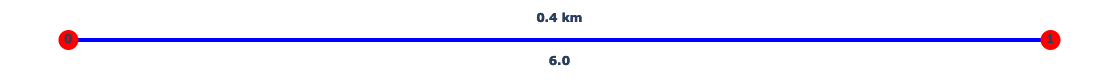

In [21]:
plot_graph(FG)

### 4. Run simulation
Now we can define the run. After we define the path that the vessel will sail, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [22]:
# Start simpy environment
t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start


# Add graph to environment
env.FG = FG

#In order from ships to know where they are going we need to add an VTS to the environment
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(env=env)

In [23]:
# we add a lock to an edge in the network
Lock_I = lock_module.IsLockComplex(env=env,
                                   name='Lock I',
                                   start_node='0',
                                   node_open='0',
                                   end_node='1',
                                   lock_length=120,
                                   lock_width=18,
                                   lock_depth=6,
                                   lineup_area_A_length=120,
                                   lineup_area_B_length=120,
                                   effective_lineup_area_B_length=120,
                                   levelling_time=1500,
                                   distance_doors_A_from_waiting_area_A=140,
                                   distance_doors_B_from_waiting_area_B=140,
                                   distance_waiting_area_A_from_start_node=0,
                                   distance_waiting_area_B_from_end_node=0,
                                   distance_lineup_area_A_to_lock_doors_A=20,
                                   distance_lineup_area_B_to_lock_doors_B=20)

In [24]:
vessel1 = create_vessel_locking(
    env=env, 
    name='Vessel1',
    origin='0', 
    destination='1',
    arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0),
    vessel_type=None, 
    L=110, 
    B=11.4, 
    T=3, 
    v=3)

vessel2 = create_vessel_locking(
    env=env, 
    name='Vessel2',
    origin='1', 
    destination='0',
    arrival_time=datetime.datetime(2024, 1, 1, 0, 10, 0),
    vessel_type=None, 
    L=110, 
    B=11.4, 
    T=3, 
    v=3)

In [25]:
env.run()

### 5. Inspect output
We can now analyse the simulation output by inspecting the data in _energy_use_ in the energycalculation object. For convenient inspection it can be loaded into a Pandas dataframe. 

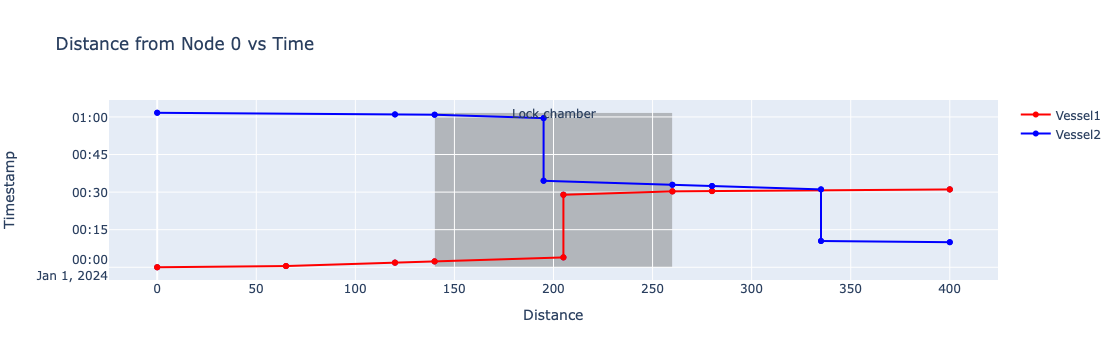

In [26]:
# Calculate the distance from node '0' for each point in the DataFrame
# Function to calculate distance
def calculate_distance(geometry):
    try:
        point1 = (env.FG.nodes['0']['geometry'].y, env.FG.nodes['0']['geometry'].x)
        point2 = (geometry.y, geometry.x)
        return geodesic(point1, point2).meters
    except KeyError as e:
        print(f"KeyError: {e}")
        return None

# Apply the function to the 'Geometry' column
vessel1_df = pd.DataFrame(vessel1.logbook)
vessel1_df['Distance'] = vessel1_df['Geometry'].apply(calculate_distance)
vessel1_df['Distance'] = vessel1_df['Distance'].round(1)

# Apply the function to the 'Geometry' column
vessel2_df = pd.DataFrame(vessel2.logbook)
vessel2_df['Distance'] = vessel2_df['Geometry'].apply(calculate_distance)
vessel2_df['Distance'] = vessel2_df['Distance'].round(1)

# Create a Plotly scatter plot with lines connecting the points
fig = px.scatter(vessel1_df, x='Distance', y='Timestamp', title='Distance from Node 0 vs Time')
fig.add_scatter(x=vessel1_df['Distance'], y=vessel1_df['Timestamp'], mode='lines+markers', name=vessel1.name,
                line=dict(color='red'), showlegend=True)
fig.add_scatter(x=vessel2_df['Distance'], y=vessel2_df['Timestamp'], mode='lines+markers', name=vessel2.name,
                line=dict(color='blue'), showlegend=True)

# Get the y-axis range after adding the scatter plot
y_range = fig.layout.yaxis.range

if y_range is None:
    # If y_range is None, calculate it based on the data
    y_range = [vessel1_df['Timestamp'].min(), vessel2_df['Timestamp'].max()]

# Add a grey patch in the background from 140 m to 260 m in the horizontal and the entire y axis in the vertical
fig.add_shape(
    type="rect",
    xref="x",
    yref="y",
    x0=140,
    x1=260,
    y0=y_range[0],
    y1=y_range[1],
    fillcolor="grey",
    opacity=0.5,
    layer="below",
    line_width=0,
)

# Add annotation for the grey patch
fig.add_annotation(
    x=200,  # Position the annotation in the middle of the patch
    y=y_range[1],  # Slightly above the top of the plot
    text="Lock chamber",
    showarrow=False,
    font=dict(size=12),
    align="center"
)
# Create the DataTables
vessel1_df['Timestamp'] = vessel1_df['Timestamp'].astype(str)
vessel1_df_2 = vessel1_df[['Message', 'Timestamp', 'Distance']]

vessel2_df['Timestamp'] = vessel2_df['Timestamp'].astype(str)
vessel2_df_2 = vessel2_df[['Message', 'Timestamp', 'Distance']]

fig

In [27]:
def calculate_distance(geometry):
    try:
        point1 = (env.FG.nodes['0']['geometry'].y, env.FG.nodes['0']['geometry'].x)
        point2 = (geometry.y, geometry.x)
        return geodesic(point1, point2).meters
    except KeyError as e:
        print(f"KeyError: {e}")
        return None

In [28]:
# Apply the function to the 'Geometry' column
vessel_df = pd.DataFrame(vessel1.logbook)
vessel_df['Distance'] = vessel_df['Geometry'].apply(calculate_distance)
vessel_df['Distance'] = vessel_df['Distance'].round(1)
vessel_df

,Message,Timestamp,Value,Geometry,Distance
0,Sailing from node 0 to node 1 start,2024-01-01 00:00:00.000000,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0 0),0.0
1,Sailing to position in line-up area start,2024-01-01 00:00:00.000000,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0 0),0.0
2,Sailing to position in line-up area stop,2024-01-01 00:00:28.888889,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.0005839049346777 0),65.0
3,Sailing to end of line-up area start,2024-01-01 00:00:28.888889,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.0005839049346777 0),65.0
4,Sailing to end of line-up area stop,2024-01-01 00:01:50.370370,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.0010779783409434 0),120.0
5,Sailing to first set of lock doors start,2024-01-01 00:01:50.370370,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.0010779783409434 0),120.0
6,Sailing to first set of lock doors stop,2024-01-01 00:02:20.000000,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.0012576413977673 0),140.0
7,Sailing to assigned location in lock start,2024-01-01 00:02:20.000000,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.0012576413977673 0),140.0
8,Sailing to assigned location in lock stop,2024-01-01 00:03:56.296296,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.001841546332445 0),205.0
9,Passing lock start,2024-01-01 00:03:56.296296,"{'origin': '0', 'destination': '1', 'route': [...",POINT (0.001841546332445 0),205.0


In [29]:
# Apply the function to the 'Geometry' column
vessel_df = pd.DataFrame(vessel2.logbook)
vessel_df['Distance'] = vessel_df['Geometry'].apply(calculate_distance)
vessel_df['Distance'] = vessel_df['Distance'].round(1)
vessel_df

,Message,Timestamp,Value,Geometry,Distance
0,Sailing from node 1 to node 0 start,2024-01-01 00:10:00.000000,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0035932 0),400.0
1,Sailing to position in line-up area start,2024-01-01 00:10:00.000000,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0035932 0),400.0
2,Sailing to position in line-up area stop,2024-01-01 00:10:28.888889,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0030092950653223 0),335.0
3,Waiting in line-up area start,2024-01-01 00:10:28.888889,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0030092950653223 0),335.0
4,Waiting in line-up area stop,2024-01-01 00:31:04.444445,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0030092950653223 0),335.0
5,Sailing to end of line-up area start,2024-01-01 00:31:04.444445,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0030092950653223 0),335.0
6,Sailing to end of line-up area stop,2024-01-01 00:32:25.925926,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0025152216590566 0),280.0
7,Sailing to first set of lock doors start,2024-01-01 00:32:25.925926,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0025152216590566 0),280.0
8,Sailing to first set of lock doors stop,2024-01-01 00:32:55.555556,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0023355586022327 0),260.0
9,Sailing to assigned location in lock start,2024-01-01 00:32:55.555556,"{'origin': '1', 'destination': '0', 'route': [...",POINT (0.0023355586022327 0),260.0
